## Image classification with neural networks

In this problem, you will train a neural network to classify satellite images. In the data/EuroSAT_RGB directory, you will find 11 subdirectories, each corresponding to a different class of land or land use: e.g. industrial, crops, rivers, forest, etc. Within each subdirectory, you will find examples in .jpg format of each type. (Thus the name of the directory in which the image lives is the class label.)

Your job is to set up a neural network that can classify the images as accurately as possible. Use an 80/20 train test split. Summarize your model and its accuracy in any way you see fit, but make you include at a minimum the following elements:

overall test-set accuracy, measured however you think is appropriate
show some of the example images from the test set, together with your model's predicted classes.
a confusion matrix showing the performance of the model on the set test, i.e. a table that cross-tabulates each test set example by (actual class, predicted class).
I strongly recommend the use of PyTorch in a Jupyter notebook for this problem; look into PyTorch's ImageFolder data set class, which will streamline things considerably.

In [3]:
import os
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

In [4]:
# Define data transformation
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [5]:
# Load the dataset
data_dir = '.../EuroSAT_RGB'
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

In [6]:
# Calculate the number of samples in the dataset and define train and test size
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

In [7]:
# Split the dataset into train and test sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [8]:
# Create data loaders for train and test sets
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
import torch.nn as nn
import torch.nn.functional as F

#Define the neural network model

class SatelliteImageClassifier(nn.Module):
    def __init__(self):
        super(SatelliteImageClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 classes in our case

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 32 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
# Initialize the model
model = SatelliteImageClassifier()

In [11]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# Train the model
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

print("Training finished!")

Epoch 1/10, Loss: 1.3302960549233227
Epoch 2/10, Loss: 0.9012432414046406
Epoch 3/10, Loss: 0.7955207604275653
Epoch 4/10, Loss: 0.6942981488605928
Epoch 5/10, Loss: 0.6256900052347126
Epoch 6/10, Loss: 0.5561172411110274
Epoch 7/10, Loss: 0.5031735934978406
Epoch 8/10, Loss: 0.456086462330536
Epoch 9/10, Loss: 0.43203326032535566
Epoch 10/10, Loss: 0.3905472657119734
Training finished!


In [13]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

#Define Predictor

def predict_images(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

In [14]:
# Predict classes for test set
test_preds, test_labels = predict_images(model, test_loader)

In [15]:
# Calculate overall test set accuracy
accuracy = accuracy_score(test_labels, test_preds)
print(f"Overall test set accuracy: {accuracy:.4f}")

Overall test set accuracy: 0.8226


In [16]:
# Create a confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)

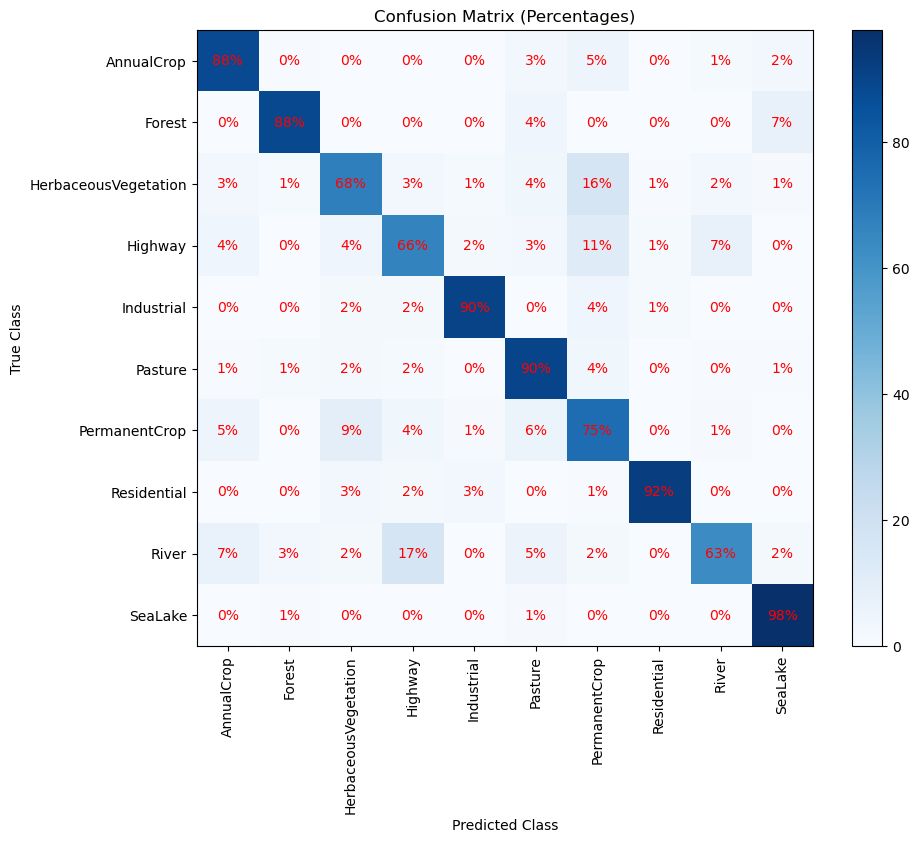

In [18]:
# Plot the confusion matrix as a heatmap
# Calculate row-wise totals
row_totals = conf_matrix.sum(axis=1, keepdims=True)

# Calculate the percentage of row totals for each cell
conf_matrix_percent = (conf_matrix / row_totals) * 100

# Plot the confusion matrix as a heatmap with percentages
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix_percent, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Percentages)")
plt.colorbar()
plt.xticks(np.arange(10), dataset.classes, rotation=90)
plt.yticks(np.arange(10), dataset.classes)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")

# Add rounded percentage values as text annotations
for i in range(len(dataset.classes)):
    for j in range(len(dataset.classes)):
        plt.text(j, i, f"{int(round(conf_matrix_percent[i, j]))}%", ha='center', va='center', color='red')

plt.show()

Overall, the model does a decent job except in some cases like some of the highways and some herbaceous vegetation getting misclassified as permanenet crop and vice-versa and some of the rivers getting mis-classified as highways.

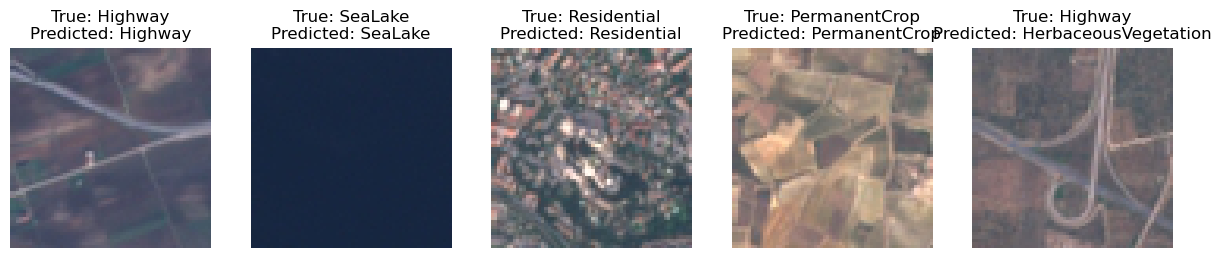

In [19]:
# Plot some example images along with predicted classes
classes = dataset.classes
num_images_to_plot = 5

fig, axs = plt.subplots(1, num_images_to_plot, figsize=(15, 3))

for i in range(num_images_to_plot):
    img, label = test_dataset[i]
    pred_label = test_preds[i]
    axs[i].imshow(np.transpose(img.numpy(), (1, 2, 0)))
    axs[i].set_title(f"True: {classes[label]}\nPredicted: {classes[pred_label]}")
    axs[i].axis('off')

plt.show()

In the given 5 examples, we can see that the prediction is correct in all but the last case where a highway gets mis-classified as herbaceous vegetation.